<a href="https://colab.research.google.com/github/iakovkh/mypython/blob/main/LSTM_example22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [0/500], Loss: 5.1456
Epoch [100/500], Loss: 1.4504
Epoch [200/500], Loss: 0.6779
Epoch [300/500], Loss: 0.4258
Epoch [400/500], Loss: 0.2980


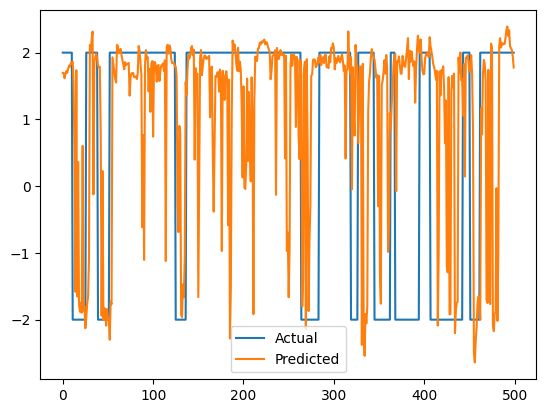

Correlation: 0.2718168003800967


In [9]:
# Configuration Section
data_file_name = '/content/sample_data/NN_cut.xlsx'
validate_file_name = '/content/sample_data/NN_contol_0.xlsx'
actual_file_name = '/content/sample_data/NN_contol.xlsx'
output_file_name = 'output.xlsx'
train_split = 0.8
normalize = False
number_of_layers = 5
number_of_neurons = 5
optimizer_name = 'adam'  # Other options: 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam'
loss_function_name = 'mse'  # Other options: 'mae', 'huber'
activation = 'relu'  # Other options: 'sigmoid', 'tanh', 'softmax', 'softplus', 'softsign', 'elu', 'selu', 'exponential'
epochs = 500
tolerance = 0.001

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Step I - General data preparation
class MyMatrix:
    def __init__(self):
        self.data = None

    def read_data_from_file(self, file_name):
        # Step 1.17 - Read data from xlsx file
        self.data = pd.read_excel(file_name)

    def normalize_data(self):
        # Step 1.18 - Normalize each column into range 0 to 1
        scaler = MinMaxScaler()
        self.data = pd.DataFrame(scaler.fit_transform(self.data), columns=self.data.columns)

    def display_console(self, column=None):
        # Step 1.19 - Display full data set or a specific column
        if column:
            print(self.data[column])
        else:
            print(self.data)

    def display_visual(self, column=None):
        # Step 1.20 - Display full data set or a specific column in a chart
        if column:
            plt.plot(self.data[column])
            plt.title(f'Column: {column}')
            plt.show()
        else:
            for col in self.data.columns:
                plt.figure()
                plt.plot(self.data[col])
                plt.title(f'Column: {col}')
                plt.show()

# Step II – Read and prepare data
# Step 2.5 - Create an object MyData of MyMatrix class
MyData = MyMatrix()

# Step 2.6 - Read the data into variable MyData from the data_file_name
MyData.read_data_from_file(data_file_name)

# Step 2.8 - Use first 80% of the data for next actions and keep 20% of data for testing
train_size = int(len(MyData.data) * train_split)
train_data = MyData.data.iloc[:train_size]
test_data = MyData.data.iloc[train_size:]

# Step 2.9 - Normalize the data
if normalize:
    MyData.normalize_data()

# Step III – Design the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(NeuralNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(self.get_activation(activation))
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(self.get_activation(activation))
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

    def get_activation(self, activation_name):
        if activation_name == 'relu':
            return nn.ReLU()
        elif activation_name == 'sigmoid':
            return nn.Sigmoid()
        elif activation_name == 'tanh':
            return nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation function: {activation_name}")

# Prepare the data
X_train = torch.tensor(train_data.iloc[:, 1:].values, dtype=torch.float32)
y_train = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(test_data.iloc[:, 1:].values, dtype=torch.float32)
y_test = torch.tensor(test_data.iloc[:, 0].values, dtype=torch.float32).view(-1, 1)

# Step 3.2 - Create a back propagation neural network
input_size = X_train.shape[1]
output_size = 1
model = NeuralNetwork(input_size, number_of_neurons, number_of_layers, output_size)

# Step 3.3 - Train the network
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

# Step IV - Testing results
# Step 4.6 - Calculate the values in column 1 using just trained neural network
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

# Save the calculated values to the file output.xlsx
output_df = pd.DataFrame({'Predicted': predictions.flatten(), 'Actual': y_test.numpy().flatten()})
output_df.to_excel(output_file_name, index=False)

# Step 4.8 - Visualize columns 1 and 2 from the output file in a chart
plt.figure()
plt.plot(output_df['Actual'], label='Actual')
plt.plot(output_df['Predicted'], label='Predicted')
plt.legend()
plt.show()

# Step 4.9 - Calculate the correlation between values in column 1 and column 2 and print it out
correlation = np.corrcoef(output_df['Actual'], output_df['Predicted'])[0, 1]
print(f'Correlation: {correlation}')
